**Importing Packages**

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import requests 
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import matplotlib.image as mimg
from geopy.geocoders import Nominatim
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import cufflinks as cf
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import iplot
import plotly.express as px
#import plotly.io as pio
#pio.renderers.default = "svg"

cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
#color = sns.color_palette()


Bad key "text.kerning_factor" on line 4 in
/anaconda3/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


**Defining the UEFA Champions League season info**

In [2]:
#url of last five seasons to retrieve data from
url = ['https://en.wikipedia.org/wiki/2018%E2%80%9319_UEFA_Champions_League', 'https://en.wikipedia.org/wiki/2017%E2%80%9318_UEFA_Champions_League','https://en.wikipedia.org/wiki/2016%E2%80%9317_UEFA_Champions_League', 'https://en.wikipedia.org/wiki/2015%E2%80%9316_UEFA_Champions_League', 'https://en.wikipedia.org/wiki/2014%E2%80%9315_UEFA_Champions_League']
#start and end index of group stage tables in the above urls
group_table_index = [{'23' : '31'}, {'15' : '23'}, {'15' : '23'}, {'15' : '23'}, {'14' : '22'}]
season = ['2018-19', '2017-18', '2016-17', '2015-16', '2014-15']

In [6]:
tables = pd.read_html(url[4])
tables[21]

,Pos,Team[ vte ],Pld,W,D,L,GF,GA,GD,Pts,Qualification,Unnamed: 11,POR,SHK,ATH,BATE
0,1,Porto,6,4,2,0,16,4,+12,14,Advance to knockout phase,NaN,—,1–1,2–1,6–0
1,2,Shakhtar Donetsk,6,2,3,1,15,4,+11,9,Advance to knockout phase,NaN,2–2,—,0–1,5–0
2,3,Athletic Bilbao,6,2,1,3,5,6,−1,7,Transfer to Europa League,NaN,0–2,0–0,—,2–0
3,4,BATE Borisov,6,1,0,5,2,24,−22,3,NaN,NaN,0–3,0–7,2–1,—


**Defining pre-processing and cleaning functions**

In [4]:
teams_league_dict = {'1899 Hoffenheim': 'German Bundesliga', 'AEK Athens': 'Super League Greece', 'APOEL': 'Cyprus First Division',
              'Ajax': 'Dutch Eredivisie', 'Anderlecht': 'Belgian First Division A', 'Arsenal': 'English Premier League',
              'Astana': 'Kazakhstan Premier League', 'Athletic Bilbao': 'Spanish La Liga', 'Atlético Madrid': 'Spanish La Liga',
              'BATE Borisov': 'Belarusian Premier League', 'Barcelona': 'Spanish La Liga', 'Basel': 'Swiss Super League',
              'Bayer Leverkusen': 'German Bundesliga', 'Bayern Munich': 'German Bundesliga', 'Benfica': 'Portuguese Primeira Liga',
              'Beşiktaş': 'Turkish Süper Lig', 'Borussia Dortmund': 'German Bundesliga', 'Borussia Mönchengladbach': 'German Bundesliga',
              'CSKA Moscow': 'Russian Premier League', 'Celtic': 'Scottish Premiership', 'Chelsea': 'English Premier League',
              'Club Brugge': 'Belgian First Division A', 'Copenhagen': 'Danish Superliga',
              'Dinamo Zagreb': 'Croatian First Football League', 'Dynamo Kyiv': 'Ukrainian Premier League',
              'Feyenoord': 'Dutch Eredivisie', 'Galatasaray': 'Turkish Süper Lig', 'Gent': 'Belgian First Division A',
              'Inter Milan': 'Italian Serie A', 'Juventus': 'Italian Serie A', 'Lyon': 'France Ligue 1',
              'Maccabi Tel Aviv': 'Israeli Premier League', 'Malmö': 'Swedish Allsvenskan',
              'Malmö FF': 'Swedish Allsvenskan', 'Manchester City': 'English Premier League', 'Manchester United': 'English Premier League',
              'Maribor': 'Slovenian PrvaLiga', 'Monaco': 'France Ligue 1',
              'Napoli': 'Italian Serie A', 'Olympiacos': 'Super League Greece', 'PSV Eindhoven': 'Dutch Eredivisie',
              'Paris Saint-Germain': 'France Ligue 1', 'Porto': 'Portuguese Primeira Liga',
              'Qarabağ': 'Azerbaijan Premier League', 'RB Leipzig': 'German Bundesliga', 'Real Madrid': 'Spanish La Liga',
              'Red Star Belgrade': 'Serbian SuperLiga', 'Roma': 'Italian Serie A', 'Rostov': 'Russian Premier League',
              'Schalke 04': 'German Bundesliga', 'Shakhtar Donetsk': 'Ukrainian Premier League',
              'Spartak Moscow': 'Russian Premier League', 'Sporting CP': 'Portuguese Primeira Liga',
              'Sevilla': 'Spanish La Liga','Tottenham Hotspur': 'English Premier League', 'Valencia': 'Spanish La Liga',
              'Viktoria Plzeň': 'Czech First League', 'Wolfsburg': 'German Bundesliga', 'Young Boys': 'Swiss Super League',
              'Zenit Saint Petersburg': 'Russian Premier League', 'Legia Warsaw': 'Polish Ekstraklasa', 'Leicester City': 'English Premier League',
              'Liverpool': 'English Premier League', 'Lokomotiv Moscow': 'Russian Premier League',
              'Ludogorets Razgrad': 'Bulgarian First League',}

def intinstr(s):
    return re.findall(r'\d+', str(s))[0]

def group_home_goals_f(s):
    s = str(s).split('–')
    if(len(s)==2):
        return int(s[0])
    else:
        return 0
    
def group_home_goals_a(s):
    s = str(s).split('–')
    if(len(s)==2):
        return int(s[1])
    else:
        return 0     
    
def group_away_goals_f(df):
    gagf = []
    for i,r in df.iterrows():
        final_val = []
        x = r['Team']
        val = df[x].tolist()
        for a in val:
            a = str(a).split('–')
            if(len(a)==2):
                final_val.append(int(a[1]))
            else:
                final_val.append(0)
        gagf.append(sum(final_val))
    return gagf

def group_away_goals_a(df):
    gaga = []
    for i,r in df.iterrows():
        final_val = []
        x = r['Team']
        val = df[x].tolist()
        for a in val:
            a = str(a).split('–')
            if(len(a)==2):
                final_val.append(int(a[0]))
            else:
                final_val.append(0)
        gaga.append(sum(final_val))
    return gaga

def qualified_round_16(s):
    if(int(s)==1 or int(s)==2):
        return 1
    else:
        return 0
    
def location(s):
    # Create geo_locator object instance
    geo_locator = Nominatim()
    loc = ''
    if(str(s) == 'Juventus'):
        s = 'Turin, Italy'
    elif(str(s) == 'Real Madrid'):
        s = 'Madrid, Spain'
    elif(str(s) == 'Manchester United'):
        s = 'Old Trafford, England'
    elif(str(s) == 'Benfica'):
        s = 'Lisbon, Portugal'
    elif(str(s) == 'Sporting CP'):
        s = 'Lisbon, Portugal'
    elif(str(s) == 'Celtic'):
        s = 'Glasgow, United Kingdom'
    elif(str(s) == 'Inter Milan'):
        s = 'Milan, Italy'
    elif(str(s) == 'Ajax'):
        s = 'Amsterdam, Netherlands'
    elif(str(s) == 'Young Boys'):
        s = 'Bern, Switzerland'
    elif(str(s) == 'Olympiacos'):
        s = 'Pireas, Greece'
    elif(str(s) == 'Red Star Belgrade'):
        s = 'Belgrade, Serbia'
    elif(str(s) == 'Viktoria Plzeň'):
        s = 'Pilsen, Czechia'
    elif(str(s) == '1899 Hoffenheim'):
        s = 'Hoffenheim, Sinsheim, Germany'
    try:
        loc = geo_locator.geocode(str(s))
    except:
        pass
    if(loc):
        return loc.latitude, loc.longitude
    else:
        return None, None  

**Preparing Data for group stage**

In [12]:
concat_group_tables = []
teams = []

for i, u in enumerate(url):       #iterating through all urls

    tables = pd.read_html(url[i]) #reading all tables from url
    group_tables = []

    start = int(list(group_table_index[i].keys())[0]) #retrieving start index of group stage tables 
    end = int(list(group_table_index[i].values())[0]) #retrieving end index of group stage tables
    year = season[i]                                  #retrieving season 

    for df in tables[start:end]:

        #new_header = df.iloc[0] #grab the first row for the header
        #df = df[1:] #take the data less the header row
        #df.columns = new_header #set the header row as the df header
        
        df.rename(columns = {'Team[ vte ]' : 'Team', 'Unnamed: 11' : 'Garbage'}, inplace=True) #renaming columns
        #print(df)
        
        #renaming short form names of teams
        team_names_col = df.columns.tolist()[-4:]
        team_names = df.loc[:,'Team'].values.tolist()
        team_names_col_replace = {}
        for i, te in enumerate(team_names_col):
            team_names_col_replace[te] = team_names[i]
        df.rename(columns = team_names_col_replace, inplace=True)  
        
        df.reset_index(inplace=True)
        #df.iloc[1,12:] = df.iloc[1,12:].shift(1)
        
        #Enriching and cleaning data
        df['Pts'] = df['Pts'].apply(intinstr)
        df.drop(columns = ['index', 'Garbage', 'Qualification'], inplace=True) #dropping unnecessary columns
        df['Season'] = year
        df['HGF'] = df.iloc[:,10].apply(group_home_goals_f) + df.iloc[:,11].apply(group_home_goals_f) + df.iloc[:,12].apply(group_home_goals_f)+ df.iloc[:,13].apply(group_home_goals_f)
        df['AGF'] = group_away_goals_f(df)
        df['HGA'] = df.iloc[:,10].apply(group_home_goals_a) + df.iloc[:,11].apply(group_home_goals_a) + df.iloc[:,12].apply(group_home_goals_a)+ df.iloc[:,13].apply(group_home_goals_a)
        df['AGA'] = group_away_goals_a(df)
        df['HGD'] = df['HGF'] - df['HGA']
        df['AGD'] = df['AGF'] - df['AGA']
        df['Round_16'] = df['Pos'].apply(qualified_round_16)
        df['League'] = df['Team'].map(teams_league_dict)
        df['Pld'] = df['Pld'].astype(int)
        df['Pts'] = df['Pts'].astype(int)
        df['GF'] = df['GF'].astype(int)
        df['GA'] = df['GA'].astype(int)
        df['GD'] = df['GF'] - df['GA']
        df['latitude'],df['longitude'] = zip(*df['Team'].apply(location))
        teams.extend(df['Team'].tolist())
        group_tables.append(df)

    concat_group_tables.append(group_tables)

#creating a dataframe of all unique teams from five UCL seasons and their leagues
df_teams = pd.DataFrame()
df_teams['Team'] = list(set(teams))
df_teams.sort_values(by=['Team'], inplace=True)
df_teams = df_teams.reset_index(drop=True)
df_teams['League'] = df_teams['Team'].map(teams_league_dict)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:82: DeprecationWarning:

Using Nominatim with the default "geopy/1.22.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.



In [13]:
group_stage_yearly = []
for temp in concat_group_tables:
    temp_list = [df[['Pos', 'Team', 'Pld', 'W', 'D', 'L', 'GF', 'GA', 'GD', 'Pts', 'Season', 'HGF','AGF', 'HGA', 'AGA', 'HGD', 'AGD', 'Round_16', 'League', 'latitude', 'longitude']] for df in temp]
    group_stage_yearly.append(pd.concat(temp_list).reset_index(drop=True))

In [14]:
group_stage_yearly[0].head()

,Pos,Team,Pld,W,D,L,GF,GA,GD,Pts,...,HGF,AGF,HGA,AGA,HGD,AGD,Round_16,League,latitude,longitude
0,1,Borussia Dortmund,6,4,1,1,10,2,8,13,...,7,3,0,2,7,1,1,German Bundesliga,51.477224,7.373194
1,2,Atlético Madrid,6,4,1,1,9,6,3,13,...,7,2,1,5,6,-3,1,Spanish La Liga,40.399810,-3.721210
2,3,Club Brugge,6,1,3,2,6,5,1,6,...,1,5,2,3,-1,2,0,Belgian First Division A,51.208553,3.226772
3,4,Monaco,6,0,1,5,2,14,-12,1,...,1,1,8,6,-7,-5,0,France Ligue 1,43.732349,7.427683
4,1,Barcelona,6,4,2,0,14,5,9,14,...,7,7,1,4,6,3,1,Spanish La Liga,41.382894,2.177432


In [34]:
@interact
def bar_plot_3(season=[0,1,2,3,4]):

    fig, axes = plt.subplots(figsize=(16,16),nrows=2, ncols=2)

    plt.subplots_adjust(wspace = 0.5)

    ax1 = group_stage_yearly[season].sort_values(by=['Pts'], ascending=0)[0:10].plot(ax=axes[0,0],kind='barh', width=0.75, x='Team',y=['Pts'])
    ax1.invert_yaxis()
    #ax = group_stage_yearly[0].sort_values(by=['Pts'], ascending=0)[0:10].plot(kind='barh',x='Team',y=['Pts','GF','GA'])

    ax2 = group_stage_yearly[season].sort_values(by=['GF'], ascending=0)[0:10].plot(ax=axes[0,1], kind='barh', width=0.75, x='Team',y=['GF'])
    ax2.invert_yaxis()

    ax3 = group_stage_yearly[season].sort_values(by=['GA'], ascending=1)[0:10].plot(ax=axes[1,0], kind='barh', width=0.75, x='Team',y=['GA'])
    ax3.invert_yaxis()

    ax3 = group_stage_yearly[season].sort_values(by=['GD'], ascending=0)[0:10].plot(ax=axes[1,1], kind='barh', width=0.75, x='Team',y=['GD'],)
    ax3.invert_yaxis()

    plt.show('png')

interactive(children=(Dropdown(description='season', options=(0, 1, 2, 3, 4), value=0), Output()), _dom_classe…

**Location of Teams in UEFA Champions League**

In [16]:
df_group_stage = (pd.concat(group_stage_yearly).reset_index(drop=True)) #concatenating all season data into one dframe

In [33]:
@interact
def map_plot(season=season):

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    fig = px.scatter_mapbox(df_plot, lat="latitude", lon="longitude", hover_name="Team",color_discrete_sequence=["fuchsia"], zoom=3, height=300, center = {'lat':50, 'lon':16})
    fig.update_layout(mapbox_style="open-street-map")
    fig.update_layout(height = 600, width = 1200, margin={"r":200,"t":0,"l":0,"b":50})
    #iplot(fig)
    fig.show('png',height = 600, width = 1400)

interactive(children=(Dropdown(description='season', options=('2018-19', '2017-18', '2016-17', '2015-16', '201…

**Exploring Teams Performance**

In [30]:
# Following interactive chart can be used to analyze multiple metrics(Points, Goals For, Goals Against, Home, Away etc.)
# to measure teams performances in different UCL seasons/year 

@interact
def bar_plot_1(season=season, performance = ['Overall', 'Home', 'Away'], top = [5,10,20]):
    
    if(performance == 'Overall'):
        metric = ['GF', 'GA', 'GD']
    elif(performance == 'Home'):
        metric = ['HGF', 'HGA', 'HGD']
    elif(performance == 'Away'):
        metric = ['AGF', 'AGA', 'AGD']

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    
    trace1 = go.Bar(y = df_plot.sort_values(by=['Pts'], ascending=False).reset_index(drop=True)[0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=['Pts'], ascending=0).reset_index(drop=True)[0:top].sort_values(by=['Pts'], ascending=True).loc[:,'Pts'], name = 'Top Winning Teams (Points)', orientation='h')
    trace2 = go.Bar(y = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[0]], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=[metric[0]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[0]], ascending=True).loc[:,metric[0]], name = 'Top Attacking Teams (Goals For)', orientation='h')
    trace3 = go.Bar(y = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)[0:top].sort_values(by=[metric[1]], ascending=False).loc[:,'Team'], x = df_plot.sort_values(by=[metric[1]], ascending=1).reset_index(drop=True)[0:top].sort_values(by=[metric[1]], ascending=False).loc[:,metric[1]], name = 'Top Defensive Teams (Goals Against)', orientation='h')
    trace4 = go.Bar(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,'Team'], x = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[2]], name = 'Top Balanced Teams (Goals Diff)', orientation='h')
    trace5 = go.Scatter(y = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[0]], x = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,metric[1]], text = df_plot.sort_values(by=[metric[2]], ascending=0).reset_index(drop=True)[0:top].sort_values(by=[metric[2]], ascending=True).loc[:,'Team'], mode='markers+text', textposition='top center', name = 'GF/GA')
    layout5 = go.Layout(yaxis=dict(range=[df_plot['GF'].min(),df_plot['GF'].max()+2]), xaxis=dict(range=[df_plot['GA'].min()-1,df_plot['GA'].max()]))
    
    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.25)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig.append_trace(trace3, 2, 1)
    fig.append_trace(trace4, 2, 2)
    fig['layout'].update( height = 800, width = 1000, title = 'Teams Performance')
    #iplot(fig)
    fig.show('png',height = 800, width = 1000)
    
    fig1 = go.Figure()
    fig1.add_trace(trace5)
    fig1.update_layout(layout5, title='Goals For Vs Goals Against',
                   xaxis_title='GA',
                   yaxis_title='GF')
    #iplot(fig1)
    fig1.show('png',height = 600, width = 800)

interactive(children=(Dropdown(description='season', options=('2018-19', '2017-18', '2016-17', '2015-16', '201…

**Exploring Country/Leagues Performance**

In [28]:
# Following interactive chart can be used to analyze multiple metrics(Goals For, Goals Against, etc.)
# to measure League/Country performances from different UCL seasons/year

#Note GF: Goals scored For
#     GA: Goals scored Against
#     GD: Goal Difference      

@interact
def bar_plot_2(season=season, metric = ['GF', 'GA', 'GD']):
    

    df_plot = df_group_stage[df_group_stage['Season'] == season].reset_index(drop=True)
    df_plot_group = df_plot.groupby(['League']).size().reset_index(name='count').sort_values(by=['count'])
    df_plot_group_gf = df_plot[['League', metric]].groupby(['League']).sum().reset_index().sort_values(by=[metric])
    df_plot_group_gf_avg = pd.merge(df_plot_group, df_plot_group_gf, on = 'League')
    df_plot_group_gf_avg[metric + '_Avg']  = df_plot_group_gf_avg[metric] / df_plot_group_gf_avg['count']
    df_plot_group_gf_avg.sort_values(by = [metric + '_Avg'], inplace = True)
       
    trace1 = go.Bar(y = df_plot_group['League'], x = df_plot_group['count'], name = 'No. of Teams/League', orientation='h')
    trace2 = go.Bar(y = df_plot_group_gf['League'], x = df_plot_group_gf[metric], name = metric + '/League', orientation='h')
    trace3 = go.Bar(y = df_plot_group_gf_avg['League'], x = df_plot_group_gf_avg[metric + '_Avg'], name = metric + '_Avg/League', orientation='h')

    fig = tools.make_subplots(rows = 2, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.5)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    fig.append_trace(trace3, 2, 2)
    fig['layout'].update(height = 800, width = 950, title = 'League wise Stats')
    #iplot(fig)
    fig.show('png',height = 800, width = 1000)


interactive(children=(Dropdown(description='season', options=('2018-19', '2017-18', '2016-17', '2015-16', '201…

**Exploring Season Stats**  

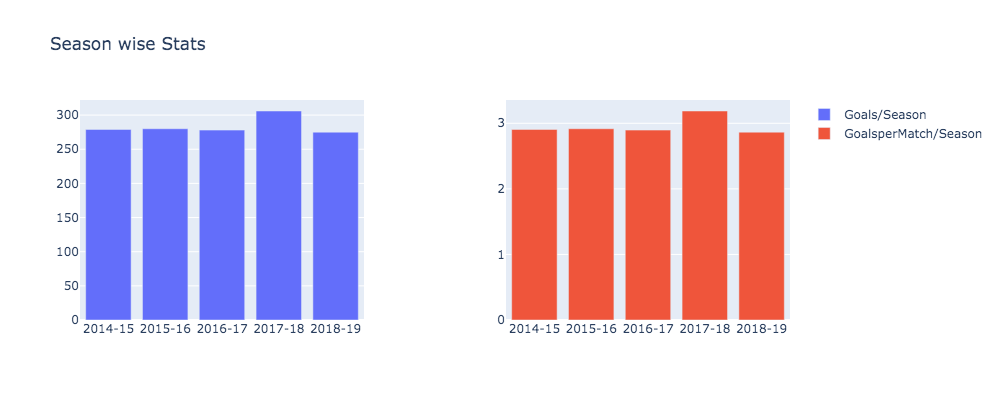

In [26]:
def bar_plot_3():
    
    total_matches = 96
    df_plot = df_group_stage[['Season','GF']].groupby(['Season']).sum().reset_index()
    df_plot['Avg_Goals'] = df_plot['GF']/total_matches
      
    trace1 = go.Bar(x = df_plot['Season'], y = df_plot['GF'], name = 'Goals/Season')
    trace2 = go.Bar(x = df_plot['Season'], y = df_plot['Avg_Goals'], name = 'GoalsperMatch/Season')
   
    fig = tools.make_subplots(rows = 1, cols = 2, vertical_spacing=0.1,horizontal_spacing=0.2)
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 1, 2)
    fig['layout'].update(height = 400, width = 1000, title = 'Season wise Stats')
    fig.show('png',height = 400, width = 1000)

bar_plot_3()